In [1]:
!pip install torch torchvision scikit-learn pandas matplotlib tqdm kagglehub

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import kagglehub
from PIL import Image


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: C:\Users\bhara\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
C:\Users\bhara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def find_images(folder_path, label):
    images = []
    for file in os.listdir(folder_path):
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            images.append((os.path.join(folder_path, file), label))
    return images

data_dir = kagglehub.dataset_download("bharathry/glaucoma-dataset-for-ai-diagnosis-v2")
data_dir = os.path.join(data_dir, "Glaucoma Dataset for AI Diagnosis")
print("Current Dir:", data_dir, "| Folders:", os.listdir(data_dir))

glaucoma_images = find_images(os.path.join(data_dir, "glaucoma"), 1)
normal_images = find_images(os.path.join(data_dir, "normal"), 0)
all_images = glaucoma_images + normal_images

train_idx, val_idx = train_test_split(
    range(len(all_images)), test_size=0.2,
    stratify=[label for _, label in all_images],
    random_state=42
)
train_split = [all_images[i] for i in train_idx]
val_split = [all_images[i] for i in val_idx]

print("Train Samples:", len(train_split), "Val Samples:", len(val_split))


Current Dir: C:\Users\bhara\.cache\kagglehub\datasets\bharathry\glaucoma-dataset-for-ai-diagnosis-v2\versions\1\Glaucoma Dataset for AI Diagnosis | Folders: ['glaucoma', 'normal']
Train Samples: 2527 Val Samples: 632


In [3]:
class CustomDataset(Dataset):
    def __init__(self, image_list, transform=None):
        self.image_list = image_list
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path, label = self.image_list[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

IMG_SIZE = 224
BATCH_SIZE = 32

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = CustomDataset(train_split, train_transform)
val_dataset = CustomDataset(val_split, val_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(device)

C:\Users\bhara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\bhara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda


In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
EPOCHS = 100
PATIENCE = 7

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
all_val_preds_by_epoch = []
all_val_labels_by_epoch = []

best_val_loss = float("inf")
best_weights = None
early_stop_counter = 0

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"[TRAIN] Epoch {epoch+1}/{EPOCHS}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    epoch_val_preds, epoch_val_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            epoch_val_preds.extend(preds.cpu().numpy())
            epoch_val_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    all_val_preds_by_epoch.append(epoch_val_preds)
    all_val_labels_by_epoch.append(epoch_val_labels)

    print(
        f"[EPOCH {epoch+1}] "
        f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% || "
        f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%"
    )

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_weights = model.state_dict()
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= PATIENCE:
            break

model.load_state_dict(best_weights)
torch.save(best_weights, "best_glaucoma_model.pth")
print("Best model saved to: best_glaucoma_model.pth")


[TRAIN] Epoch 1/100: 100%|██████████| 79/79 [01:51<00:00,  1.41s/it]


[EPOCH 1] Train Loss: 0.2032 | Train Acc: 90.58% || Val Loss: 0.1035 | Val Acc: 96.20%


[TRAIN] Epoch 2/100: 100%|██████████| 79/79 [01:40<00:00,  1.28s/it]


[EPOCH 2] Train Loss: 0.1340 | Train Acc: 94.46% || Val Loss: 0.1101 | Val Acc: 95.09%


[TRAIN] Epoch 3/100: 100%|██████████| 79/79 [01:45<00:00,  1.33s/it]


[EPOCH 3] Train Loss: 0.1176 | Train Acc: 94.62% || Val Loss: 0.1019 | Val Acc: 95.41%


[TRAIN] Epoch 4/100: 100%|██████████| 79/79 [01:42<00:00,  1.29s/it]


[EPOCH 4] Train Loss: 0.1079 | Train Acc: 94.97% || Val Loss: 0.1321 | Val Acc: 95.41%


[TRAIN] Epoch 5/100: 100%|██████████| 79/79 [01:37<00:00,  1.23s/it]


[EPOCH 5] Train Loss: 0.0945 | Train Acc: 96.28% || Val Loss: 0.1097 | Val Acc: 94.78%


[TRAIN] Epoch 6/100: 100%|██████████| 79/79 [02:14<00:00,  1.70s/it]


[EPOCH 6] Train Loss: 0.1032 | Train Acc: 95.65% || Val Loss: 0.1778 | Val Acc: 95.09%


[TRAIN] Epoch 7/100: 100%|██████████| 79/79 [03:27<00:00,  2.62s/it]


[EPOCH 7] Train Loss: 0.0912 | Train Acc: 96.32% || Val Loss: 0.0996 | Val Acc: 95.57%


[TRAIN] Epoch 8/100: 100%|██████████| 79/79 [03:34<00:00,  2.71s/it]


[EPOCH 8] Train Loss: 0.0730 | Train Acc: 96.91% || Val Loss: 0.1083 | Val Acc: 95.89%


[TRAIN] Epoch 9/100: 100%|██████████| 79/79 [03:09<00:00,  2.39s/it]


[EPOCH 9] Train Loss: 0.0639 | Train Acc: 97.11% || Val Loss: 0.4607 | Val Acc: 95.25%


[TRAIN] Epoch 10/100: 100%|██████████| 79/79 [03:30<00:00,  2.66s/it]


[EPOCH 10] Train Loss: 0.0723 | Train Acc: 97.27% || Val Loss: 0.1463 | Val Acc: 93.99%


[TRAIN] Epoch 11/100: 100%|██████████| 79/79 [03:27<00:00,  2.62s/it]


[EPOCH 11] Train Loss: 0.0606 | Train Acc: 97.82% || Val Loss: 0.3416 | Val Acc: 95.09%


[TRAIN] Epoch 12/100: 100%|██████████| 79/79 [03:29<00:00,  2.65s/it]


[EPOCH 12] Train Loss: 0.0567 | Train Acc: 97.86% || Val Loss: 0.1113 | Val Acc: 94.94%


[TRAIN] Epoch 13/100: 100%|██████████| 79/79 [02:20<00:00,  1.78s/it]


[EPOCH 13] Train Loss: 0.0479 | Train Acc: 98.10% || Val Loss: 0.1196 | Val Acc: 96.52%


[TRAIN] Epoch 14/100: 100%|██████████| 79/79 [02:07<00:00,  1.61s/it]


[EPOCH 14] Train Loss: 0.0431 | Train Acc: 98.65% || Val Loss: 0.2309 | Val Acc: 94.94%
Best model saved to: best_glaucoma_model.pth


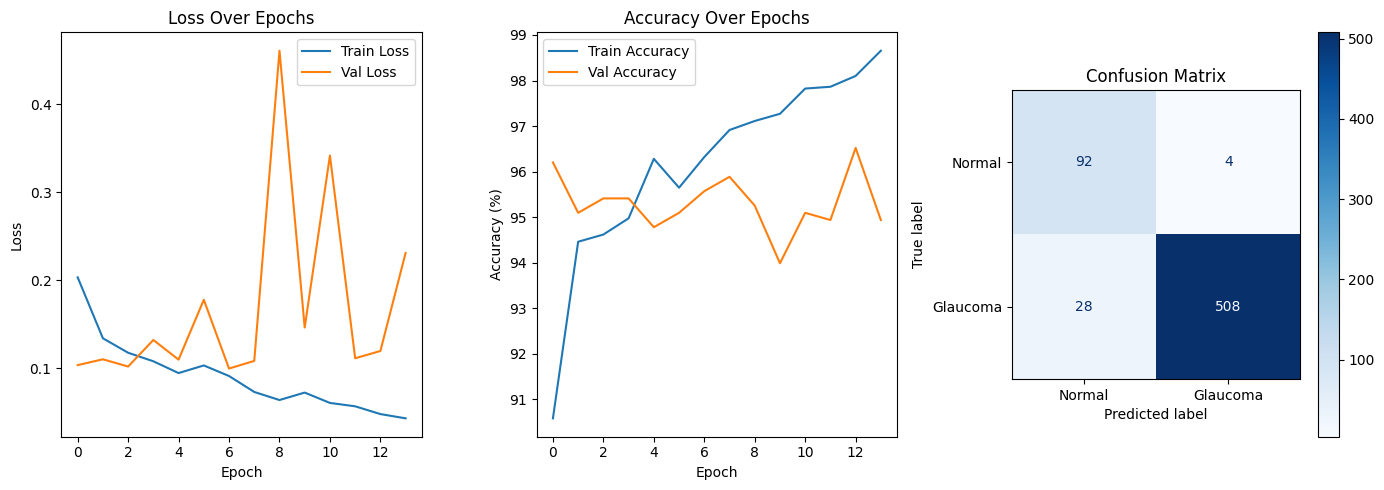

In [5]:
import os
os.makedirs("results", exist_ok=True)

plt.figure(figsize=(14, 5))

# Plot loss
plt.subplot(1, 3, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()

# Plot accuracy
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Over Epochs")
plt.legend()

# Plot confusion matrix only if available
plt.subplot(1, 3, 3)
if all_val_preds_by_epoch and all_val_labels_by_epoch:
    cm = confusion_matrix(all_val_labels_by_epoch[-1], all_val_preds_by_epoch[-1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Glaucoma"])
    disp.plot(cmap="Blues", values_format="d", ax=plt.gca())
    plt.title("Confusion Matrix")
else:
    plt.axis("off")
    plt.title("No Confusion Matrix (empty prediction list)")

plt.tight_layout()
plt.savefig("results/resnet50_glaucoma_metrics.png")
plt.show()


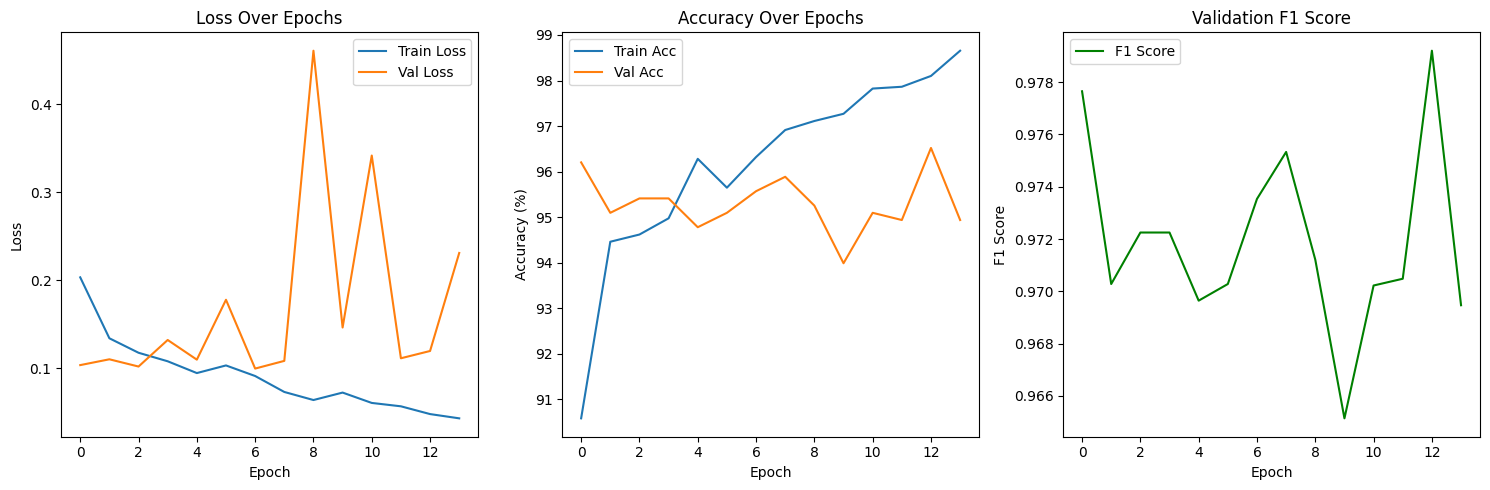

In [6]:
from sklearn.metrics import accuracy_score, recall_score, f1_score

# Prepare metric lists
val_metrics = {
    "accuracy": [],
    "recall": [],
    "f1_score": []
}

# Compute metrics for each epoch
for epoch_preds, epoch_labels in zip(all_val_preds_by_epoch, all_val_labels_by_epoch):
    val_metrics["accuracy"].append(accuracy_score(epoch_labels, epoch_preds))
    val_metrics["recall"].append(recall_score(epoch_labels, epoch_preds))
    val_metrics["f1_score"].append(f1_score(epoch_labels, epoch_preds))

# Plotting
plt.figure(figsize=(15, 5))

# Plot loss
plt.subplot(1, 3, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()

# Plot accuracy
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Over Epochs")
plt.legend()

# Plot F1 Score
plt.subplot(1, 3, 3)
plt.plot(val_metrics["f1_score"], label="F1 Score", color="green")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Validation F1 Score")
plt.legend()

plt.tight_layout()
plt.savefig("glaucoma_training_results.png")
plt.show()